# Forest Fires

1. Title: Forest Fires

2. Sources
   Created by: Paulo Cortez and An�bal Morais (Univ. Minho) @ 2007
   
3. Past Usage:

   P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data.
   In Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, 
   December, 2007. (http://www.dsi.uminho.pt/~pcortez/fires.pdf)
   
   In the above reference, the output "area" was first transformed with a ln(x+1) function.
   Then, several Data Mining methods were applied. After fitting the models, the outputs were
   post-processed with the inverse of the ln(x+1) transform. Four different input setups were
   used. The experiments were conducted using a 10-fold (cross-validation) x 30 runs. Two
   regression metrics were measured: MAD and RMSE. A Gaussian support vector machine (SVM) fed
   with only 4 direct weather conditions (temp, RH, wind and rain) obtained the best MAD value:
   12.71 +- 0.01 (mean and confidence interval within 95% using a t-student distribution). The
   best RMSE was attained by the naive mean predictor. An analysis to the regression error curve
   (REC) shows that the SVM model predicts more examples within a lower admitted error. In effect,
   the SVM model predicts better small fires, which are the majority. 
 
4. Relevant Information:

   This is a very difficult regression task. It can be used to test regression methods. Also,
   it could be used to test outlier detection methods, since it is not clear how many outliers
   are there. Yet, the number of examples of fires with a large burned area is very small.

5. Number of Instances: 517 

6. Number of Attributes: 12 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

7. Attribute information:

   For more information, read [Cortez and Morais, 2007].

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform). 

산불 데이터들을 통해서 산불 예측 모델을 만드는 것이 목표이다.

## 설정

In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import numpy.random as rnd
import os
import tensorflow as tf
import pandas as pd
from pandas.plotting import scatter_matrix

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='HCR Batang')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "forestfires"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path_of_fig = os.path.join(IMAGES_PATH, fig_id)
    if os.path.isdir(path_of_fig) == False:
        os.makedirs(path_of_fig)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def load_forestfires_data(forestfires_path = 'forestfires.csv'):
    return pd.read_csv(forestfires_path)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def make_rand_float(x):
    return x+np.random.rand()

def bottom_clipper_80(x):
    if x < 80:
        return 80
    else:
        return x

def top_clipper_25(x):
    if x > 25:
        return 25
    else:
        return x
    
def top_clipper_100(x):
    if x > 100:
        return 100
    else:
        return x
    
# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
def reset_index(X):
    X_reset_index = X.reset_index().copy()
    del X_reset_index["index"]
    return X_reset_index

def make_array_X(X):
    array = []
    for i in range(len(X)):
        tmp = []
        for j in range(12):
            tmp.append(X.iloc[i][j])
        array.append(tmp)
    return array

def make_array_y(y):
    array = []
    for i in range(len(y)):
        array.append(y["area"][i])
    return array

def make_array_feature(y, feature):
    array = []
    for i in range(len(y)):
        array.append([y[feature][i]])
    return array

In [2]:
## Back-Up Code

# Download data
forestfires = load_forestfires_data()

# Month, Day 숫자화
forestfires["month"].loc[forestfires["month"] == "jan"] = 1
forestfires["month"].loc[forestfires["month"] == "feb"] = 2
forestfires["month"].loc[forestfires["month"] == "mar"] = 3
forestfires["month"].loc[forestfires["month"] == "apr"] = 4
forestfires["month"].loc[forestfires["month"] == "may"] = 5
forestfires["month"].loc[forestfires["month"] == "jun"] = 6
forestfires["month"].loc[forestfires["month"] == "jul"] = 7
forestfires["month"].loc[forestfires["month"] == "aug"] = 8
forestfires["month"].loc[forestfires["month"] == "sep"] = 9
forestfires["month"].loc[forestfires["month"] == "oct"] = 10
forestfires["month"].loc[forestfires["month"] == "nov"] = 11
forestfires["month"].loc[forestfires["month"] == "dec"] = 12

forestfires["day"].loc[forestfires["day"] == "mon"] = 1
forestfires["day"].loc[forestfires["day"] == "tue"] = 2
forestfires["day"].loc[forestfires["day"] == "wed"] = 3
forestfires["day"].loc[forestfires["day"] == "thu"] = 4
forestfires["day"].loc[forestfires["day"] == "fri"] = 5
forestfires["day"].loc[forestfires["day"] == "sat"] = 6
forestfires["day"].loc[forestfires["day"] == "sun"] = 7

# Data Split
train_set, test_set = split_train_test(forestfires, 0.2)

# 인덱스 초기화
forestfires_new_index = train_set.reset_index().copy()
del forestfires_new_index["index"]

# X,Y 난수 추가
forestfires_new_index["X"] = forestfires_new_index["X"].apply(make_rand_float)
forestfires_new_index["Y"] = forestfires_new_index["Y"].apply(make_rand_float)

# FFMC 수정
## Clipping
forestfires_new_index["FFMC"] = forestfires_new_index["FFMC"].apply(bottom_clipper_80)

# ISI 수정
## Clipping
forestfires_new_index["ISI"] = forestfires_new_index["ISI"].apply(top_clipper_25)

# area 수정
## Clipping
forestfires_new_index["area"] = forestfires_new_index["area"].apply(top_clipper_100)

# train을 위해 데이터 라벨과 나누어 주기
X_train, y_train = forestfires_new_index.loc[:,:"rain"],forestfires_new_index.loc[:,"area":]
X_test, y_test = test_set.loc[:,:"rain"], test_set.loc[:,"area":]
# X_train = X_train.astype(np.float32)
# X_test = X_test.astype(np.float32)
# y_train = y_train.astype(np.int32)
# y_test = y_test.astype(np.int32)
# X_valid, X_train = X_train[:100], X_train[100:]
# y_valid, y_train = y_train[:100], y_train[100:]
# ## 인덱스 초기화
# X_train = reset_index(X_train)
# y_train = reset_index(y_train)
# X_test = reset_index(X_test)
# y_test = reset_index(y_test)
# X_valid = reset_index(X_valid)
# y_valid = reset_index(y_valid)

c:\users\backg\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## 1. Data Pre-processing

In [2]:
def load_forestfires_data(forestfires_path = 'forestfires.csv'):
    return pd.read_csv(forestfires_path)

In [64]:
forestfires = load_forestfires_data()
forestfires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [28]:
forestfires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [29]:
forestfires.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A6F21AC518>,
      dtype=object)

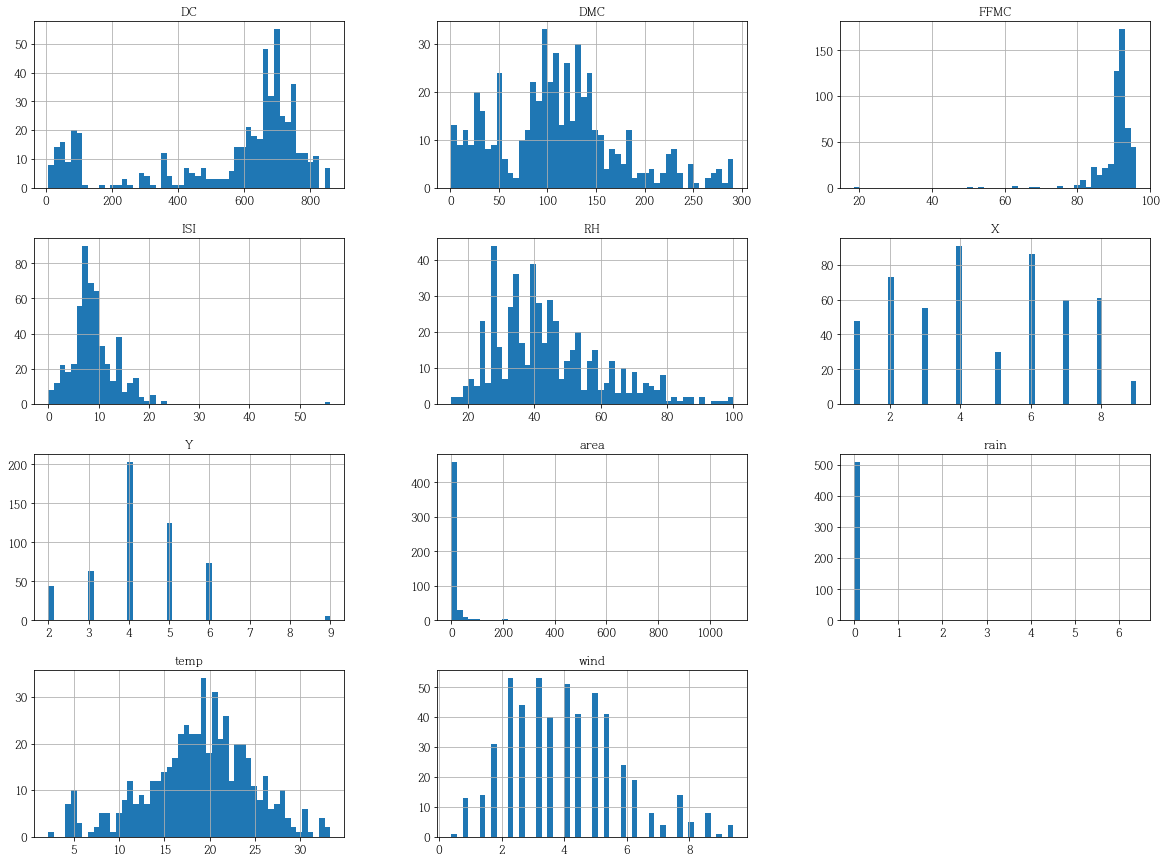

In [30]:
forestfires.hist(bins=50, figsize=(20,15))

### month와 day 숫자화 하기

데이터를 좀더 쉽게 처리하기 위해 datatype이 Object인 것들을 int로 바꾸어 주었다. 월들간, 요일간은 연관이 있기때문에 onehot으로 변환은 하지 않았다.

In [65]:
forestfires["month"].loc[forestfires["month"] == "jan"] = 1
forestfires["month"].loc[forestfires["month"] == "feb"] = 2
forestfires["month"].loc[forestfires["month"] == "mar"] = 3
forestfires["month"].loc[forestfires["month"] == "apr"] = 4
forestfires["month"].loc[forestfires["month"] == "may"] = 5
forestfires["month"].loc[forestfires["month"] == "jun"] = 6
forestfires["month"].loc[forestfires["month"] == "jul"] = 7
forestfires["month"].loc[forestfires["month"] == "aug"] = 8
forestfires["month"].loc[forestfires["month"] == "sep"] = 9
forestfires["month"].loc[forestfires["month"] == "oct"] = 10
forestfires["month"].loc[forestfires["month"] == "nov"] = 11
forestfires["month"].loc[forestfires["month"] == "dec"] = 12

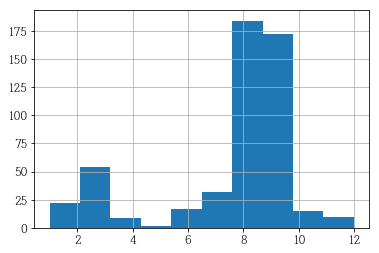

In [32]:
forestfires["month"].hist()

In [66]:
forestfires["day"].loc[forestfires["day"] == "mon"] = 1
forestfires["day"].loc[forestfires["day"] == "tue"] = 2
forestfires["day"].loc[forestfires["day"] == "wed"] = 3
forestfires["day"].loc[forestfires["day"] == "thu"] = 4
forestfires["day"].loc[forestfires["day"] == "fri"] = 5
forestfires["day"].loc[forestfires["day"] == "sat"] = 6
forestfires["day"].loc[forestfires["day"] == "sun"] = 7

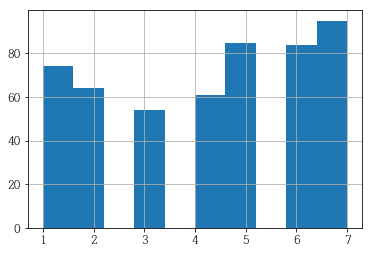

In [34]:
forestfires["day"].hist()

### 데이터 나누기
데이터를 train 데이터와 test 데이터로 나눈다.

In [67]:
train_set, test_set = split_train_test(forestfires, 0.2)
print(len(train_set), "train +", len(test_set), "test")

414 train + 103 test


In [37]:
train_set.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
500,8,6,8,2,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.0
93,8,6,8,7,91.4,142.4,601.4,10.6,18.2,43,4.9,0.0,0.0
64,2,2,8,1,91.1,103.2,638.8,5.8,23.1,31,3.1,0.0,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [38]:
test_set.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
30,6,3,9,5,94.3,85.1,692.3,15.9,25.4,24,3.6,0.0,0.00
307,3,4,9,7,89.6,84.1,714.3,5.7,23.8,35,3.6,0.0,5.18
173,4,4,9,1,90.9,126.5,686.5,7.0,17.7,39,2.2,0.0,3.07
489,4,4,8,3,95.1,141.3,605.8,17.7,20.6,58,1.3,0.0,0.00
158,2,4,8,3,92.1,111.2,654.1,9.6,20.5,35,4.0,0.0,1.64


In [39]:
train_set.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,4.632850,4.258454,7.475845,4.272947,90.524155,112.003382,548.772464,8.908937,18.992754,44.285024,4.005556,0.021739,13.590797
std,2.320658,1.210672,2.252391,2.060911,5.912378,65.172221,247.545567,4.668569,5.798208,16.345125,1.739721,0.321333,69.639098
min,1.000000,2.000000,1.000000,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.900000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,69.975000,432.025000,6.500000,15.500000,32.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,108.300000,664.350000,8.250000,19.300000,42.000000,4.000000,0.000000,0.530000
75%,7.000000,5.000000,9.000000,6.000000,92.875000,142.400000,713.675000,10.600000,22.900000,53.000000,4.900000,0.000000,6.602500
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [8]:
forestfires = train_set.copy()

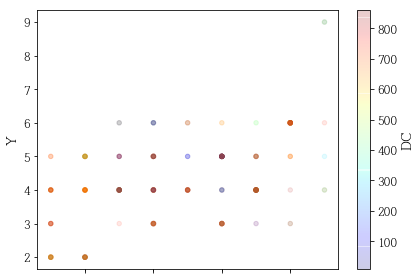

In [41]:
ax = forestfires.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="DC", cmap=plt.get_cmap("jet"), colorbar=True)
ax.set(xlabel="X", ylabel="Y")
save_fig("scatter_plot")

좀더 직관적인 관찰을 위해서 (x,y)좌표에 난수를 섞어 분산시켜보았다.

In [32]:
# 인덱스 초기화
forestfires_new_index = forestfires.reset_index().copy()
del forestfires_new_index["index"]
forestfires_new_index["X"][0]

7

1사분면에서만 관찰하고 싶어서 난수를 양수로만 주었다.

In [70]:
forestfires_new_index.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [78]:
def make_rand_float(x):
    return x+np.random.rand()

In [83]:
forestfires_new_index["X"] = forestfires_new_index["X"].apply(make_rand_float)
forestfires_new_index["Y"] = forestfires_new_index["Y"].apply(make_rand_float)

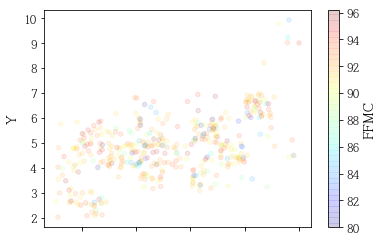

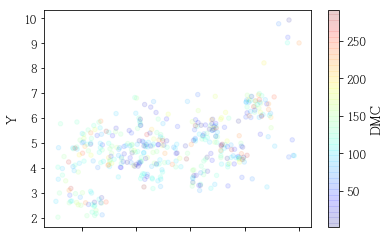

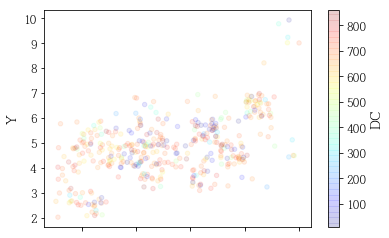

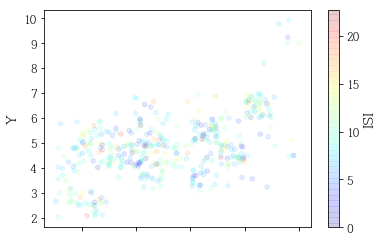

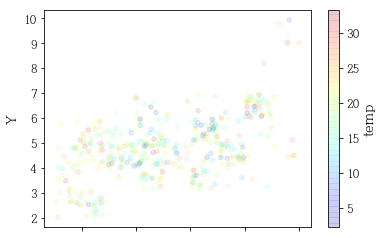

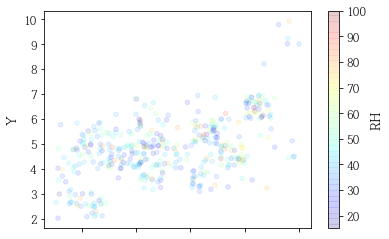

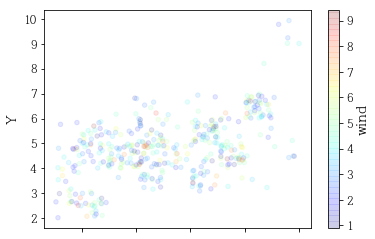

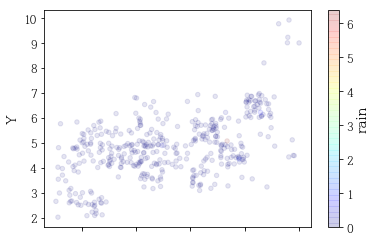

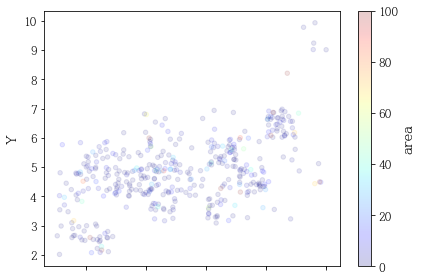

In [22]:
ax1 = forestfires_new_index.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="FFMC", cmap=plt.get_cmap("jet"), colorbar=True)
ax1.set(xlabel="X", ylabel="Y")

ax2 = forestfires_new_index.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="DMC", cmap=plt.get_cmap("jet"), colorbar=True)
ax2.set(xlabel="X", ylabel="Y")

ax3 = forestfires_new_index.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="DC", cmap=plt.get_cmap("jet"), colorbar=True)
ax3.set(xlabel="X", ylabel="Y")

ax4 = forestfires_new_index.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="ISI", cmap=plt.get_cmap("jet"), colorbar=True)
ax4.set(xlabel="X", ylabel="Y")

ax5 = forestfires_new_index.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="temp", cmap=plt.get_cmap("jet"), colorbar=True)
ax5.set(xlabel="X", ylabel="Y")

ax6 = forestfires_new_index.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="RH", cmap=plt.get_cmap("jet"), colorbar=True)
ax6.set(xlabel="X", ylabel="Y")

ax7 = forestfires_new_index.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="wind", cmap=plt.get_cmap("jet"), colorbar=True)
ax7.set(xlabel="X", ylabel="Y")

ax8 = forestfires_new_index.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="rain", cmap=plt.get_cmap("jet"), colorbar=True)
ax8.set(xlabel="X", ylabel="Y")

ax9 = forestfires_new_index.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="area", cmap=plt.get_cmap("jet"), colorbar=True)
ax9.set(xlabel="X", ylabel="Y")

save_fig("scatter_plot")

비교적 일관적 색상을 가진 FFMC, ISI, rain은 수정이 필요해 보인다.

각 특성들 간 연관성을 보기위해 scatter_matrix를 사용하였다.

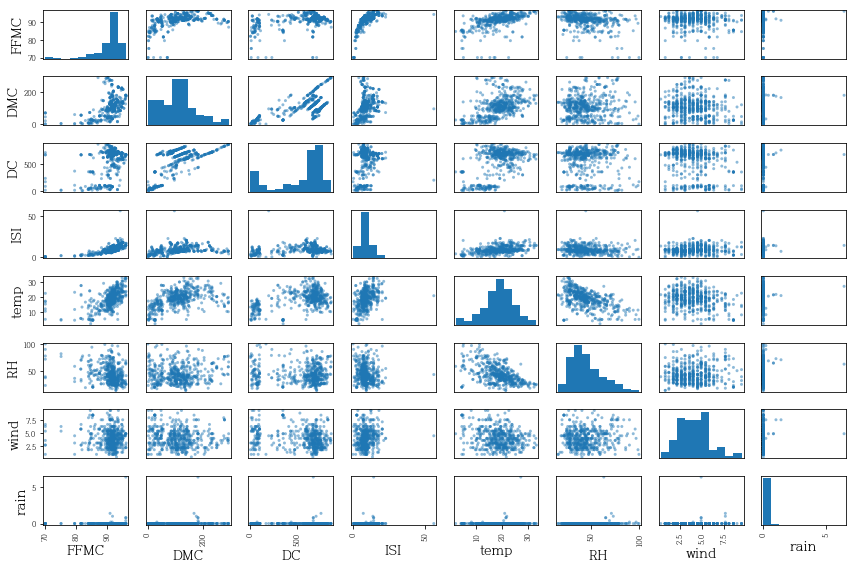

In [46]:
from pandas.plotting import scatter_matrix

attributes = ["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind","rain"]
scatter_matrix(forestfires_new_index[attributes], figsize=(12,8))
save_fig("scatter_matrix_plot")

#### FFMC 자료 수정
~~FFMC자료를 평균화 하기 위해 mean으로 나누어 주었다~~ 
<br>
mean으로 나눠줄 필요 없다.

In [12]:
# 의미없는 것
mean_FFMC = forestfires_new_index["FFMC"].mean()
forestfires_new_index["FFMC"] = forestfires_new_index["FFMC"]/mean_FFMC

다시 scatter_matrix 확인

다른 방법으로 시도. 최소값을를 70으로 클리핑을 시켜봄

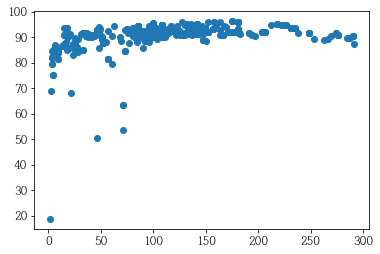

In [36]:
plt.scatter(forestfires_new_index["DMC"], forestfires_new_index["FFMC"])

In [38]:
y_1 = forestfires_new_index["FFMC"].copy()

In [49]:
def bottom_clipper_80(x):
    if x < 80:
        return 80
    else:
        return x

In [50]:
y_2 = y_1.apply(my_clipper1)

In [51]:
y_2.describe()

count    517.000000
mean      91.001741
std        3.274434
min       80.000000
25%       90.200000
50%       91.600000
75%       92.900000
max       96.200000
Name: FFMC, dtype: float64

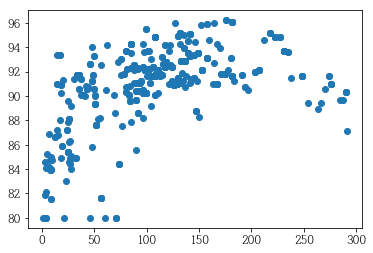

In [52]:
plt.scatter(forestfires_new_index["DMC"], y_2)

In [53]:
forestfires_new_index["FFMC"] = y_2

In [88]:
forestfires_new_index["FFMC"] = forestfires_new_index["FFMC"].apply(bottom_clipper_80)

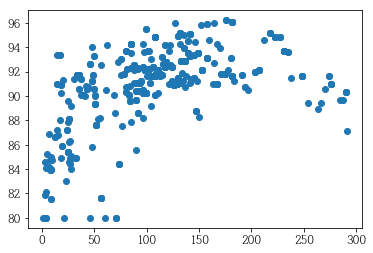

In [89]:
plt.scatter(forestfires_new_index["DMC"], forestfires_new_index["FFMC"])

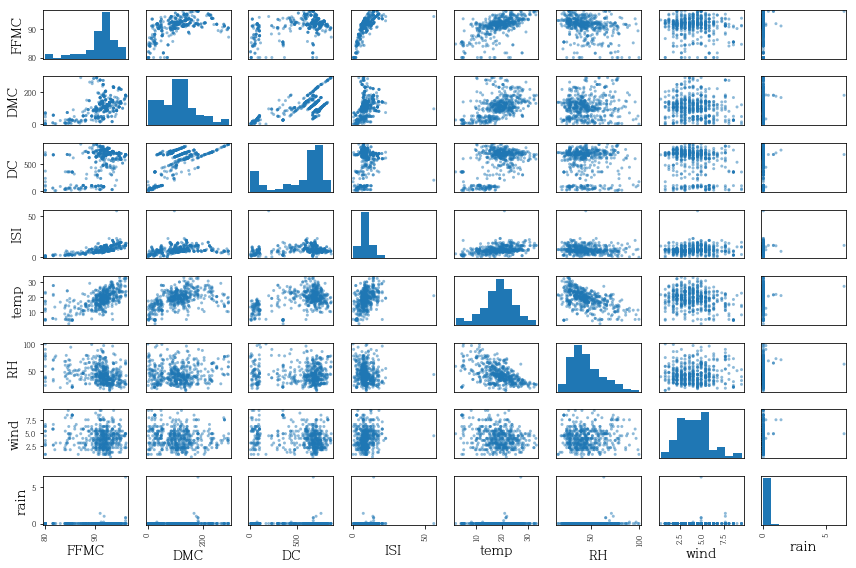

In [55]:
scatter_matrix(forestfires_new_index[attributes], figsize=(12,8))
save_fig("scatter_matrix_plot_fixed_FFMC2")

[Text(0, 0.5, 'Y'), Text(0.5, 0, 'X')]

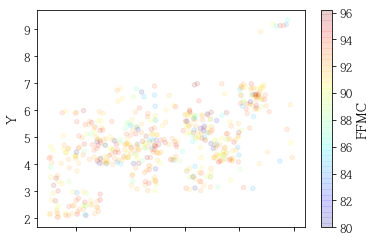

In [90]:
ax1 = forestfires_new_index.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="FFMC", cmap=plt.get_cmap("jet"), colorbar=True)
ax1.set(xlabel="X", ylabel="Y")

#### ISI데이터 수정

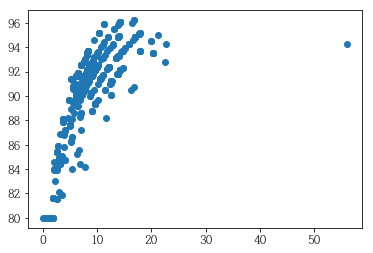

In [57]:
plt.scatter(forestfires_new_index["ISI"], forestfires_new_index["FFMC"])

In [61]:
forestfires_new_index["ISI"].describe()

count    517.000000
mean       9.021663
std        4.559477
min        0.000000
25%        6.500000
50%        8.400000
75%       10.800000
max       56.100000
Name: ISI, dtype: float64

마찬가지로 클리핑을 해보았다.

In [96]:
def top_clipper_25(x):
    if x > 25:
        return 25
    else:
        return x
    
forestfires_new_index["ISI"] = forestfires_new_index["ISI"].apply(top_clipper_25)

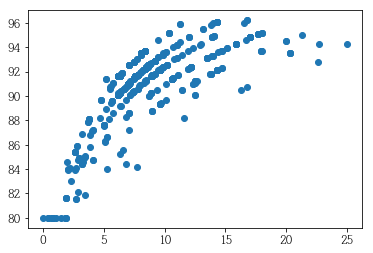

In [97]:
plt.scatter(forestfires_new_index["ISI"], forestfires_new_index["FFMC"])

[Text(0, 0.5, 'Y'), Text(0.5, 0, 'X')]

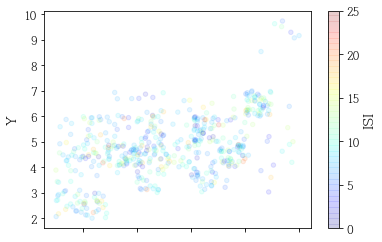

In [98]:
ax4 = forestfires_new_index.plot(kind='scatter', x="X", y="Y", alpha=0.1, c="ISI", cmap=plt.get_cmap("jet"), colorbar=True)
ax4.set(xlabel="X", ylabel="Y")

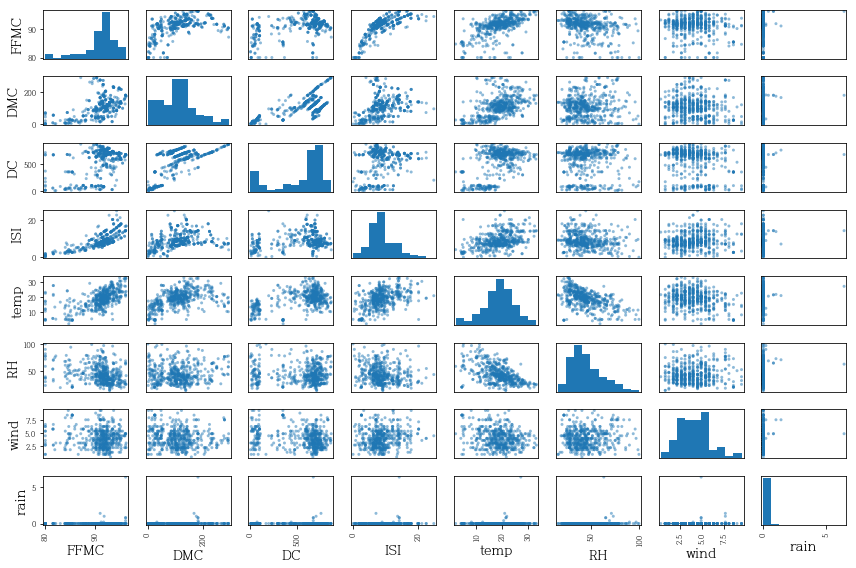

In [99]:
scatter_matrix(forestfires_new_index[attributes], figsize=(12,8))
save_fig("scatter_matrix_plot_fixed_ver2")

rain을 제외한 데이터들이 느낌있게 퍼졌다. (rain은 애초에 0으로 대부분이 이루어진 데이터라 건드리지 않았다.)

In [215]:
X_train, y_train = forestfires_new_index.loc[:,:"rain"],forestfires_new_index.loc[:,"area":]
X_test, y_test = test_set.loc[:,:"rain"], test_set.loc[:,"area":]
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:100], X_train[100:]
y_valid, y_train = y_train[:100], y_train[100:]

In [216]:
X_train = reset_index(X_train)
y_train = reset_index(y_train)
X_test = reset_index(X_test)
y_test = reset_index(y_test)
X_valid = reset_index(X_valid)
y_valid = reset_index(y_valid)

In [217]:
def make_array_X(X):
    array = []
    for i in range(len(X)):
        tmp = []
        for j in range(12):
            tmp.append(X.iloc[i][j])
        array.append(tmp)
    return array

def make_array_y(y):
    array = []
    for i in range(len(y)):
        array.append(y["area"][i])
    return array

In [3]:
X_train = make_array_X(X_train)
y_train = make_array_y(y_train)
X_test = make_array_X(X_test)
y_test = make_array_y(y_test)
X_valid = make_array_X(X_valid)
y_valid = make_array_y(y_valid)

In [4]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.int32)
y_test = np.array(y_test).astype(np.int32)

## 2. Chosing and Training Model

### ANN

In [11]:
reset_graph()

n_inputs = 12
n_hidden1 = 100
n_hidden2 = 50
n_outputs = len(forestfires_new_index)

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name = "X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [12]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name = "hidden1", activation= tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name = "hidden2", activation= tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits)

In [13]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [14]:
learning_rate = 0.01 

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [15]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [16]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
n_batches = 30
batch_size = 30

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            try:
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            except:
                pass
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.54
1 검증 세트 정확도: 0.54
2 검증 세트 정확도: 0.52
3 검증 세트 정확도: 0.52
4 검증 세트 정확도: 0.52
5 검증 세트 정확도: 0.52
6 검증 세트 정확도: 0.52
7 검증 세트 정확도: 0.52
8 검증 세트 정확도: 0.52
9 검증 세트 정확도: 0.52
10 검증 세트 정확도: 0.52
11 검증 세트 정확도: 0.53
12 검증 세트 정확도: 0.53
13 검증 세트 정확도: 0.53
14 검증 세트 정확도: 0.54
15 검증 세트 정확도: 0.53
16 검증 세트 정확도: 0.54
17 검증 세트 정확도: 0.53
18 검증 세트 정확도: 0.53
19 검증 세트 정확도: 0.53


생각대로 안됨...
<br><br>

## 다중회기분석
<br>
다중회기를 이용해보자!

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

y = make_array_y(y_train)
y_real = make_array_y(reset_index(y_test))

In [5]:
def check_min_error(min_error, new_error,degree, printout=False):
    if min_error> new_error:
        if printout:
            print("Degree : ", degree, "Error : ", new_error)
        return new_error
    else:
        return min_error

### FFMC

In [6]:
X = make_array_feature(X_train,feature="FFMC")
test_X = make_array_feature(reset_index(X_test), feature="FFMC")
min_error = 50000

for degree in range(1,100):
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    X_new_poly = poly_features.transform(test_X)
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, y)
    y_new = lin_reg.predict(X_new_poly)
    train_errors = mean_squared_error(y_real, y_new)
    min_error = check_min_error(min_error, train_errors,degree, printout=True) 

Degree :  1 Error :  12022.489477060695
Degree :  2 Error :  12022.329319974595
Degree :  6 Error :  12022.13514928093
Degree :  7 Error :  12021.978620806345
Degree :  8 Error :  12021.765202483659
Degree :  9 Error :  12021.532728248563
Degree :  10 Error :  12021.283779334446
Degree :  11 Error :  12021.022327057499
Degree :  12 Error :  12020.752603720493
Degree :  13 Error :  12020.478878568718
Degree :  14 Error :  12020.205357409657
Degree :  15 Error :  12019.936075520955
Degree :  16 Error :  12019.67483017497
Degree :  17 Error :  12019.42519856237
Degree :  18 Error :  12019.190192156577
Degree :  19 Error :  12018.97278853161
Degree :  20 Error :  12018.77537432651
Degree :  21 Error :  12018.600042969154
Degree :  22 Error :  12018.448509760605
Degree :  23 Error :  12018.322161298724
Degree :  24 Error :  12018.222075875554
Degree :  25 Error :  12018.149033252143
Degree :  26 Error :  12018.103445248871
Degree :  27 Error :  12018.085711576994


In [7]:
## Degree 27
poly_features = PolynomialFeatures(degree=27, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_new_poly = poly_features.transform(test_X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
y_new = lin_reg.predict(X_new_poly)
train_errors = mean_squared_error(y_real, y_new)